In [13]:
from project import Projection
from Problem import Problem
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from Phase2_dynamic import optim_Scalarization
from main_dynamic import load_config
from utils import visualize_pareto_front, generate_pareto_grid

In [2]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math
import itertools


In [3]:
case = "_Ex_7_1"

# Prob

In [4]:
def f1(x):
    return x[0]
def f2(x):
    return (x[0] - 1)**2
def f(x):
    return np.array([
        x[0],
        (x[0]-1)**2
    ])
#--------------- C --------------------#
def c1(x):
    return x[0]
def c2(x):
    return -x[0] + 1


#--------------- Q --------------------#
def q1(y):
    return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2

def q_plus(y):
    center = .4
    radius_sq = 0.2**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 1
bounds_x = None
cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

<>:47: SyntaxWarning: invalid escape sequence '\i'
<>:47: SyntaxWarning: invalid escape sequence '\i'
C:\Users\Admin\AppData\Local\Temp\ipykernel_16728\980806981.py:47: SyntaxWarning: invalid escape sequence '\i'
  plt.plot(y1_vals, y2_vals, color='blue', linewidth=2.5, label='Image Space ($f(x)$ for $x \in [0,1]$)')


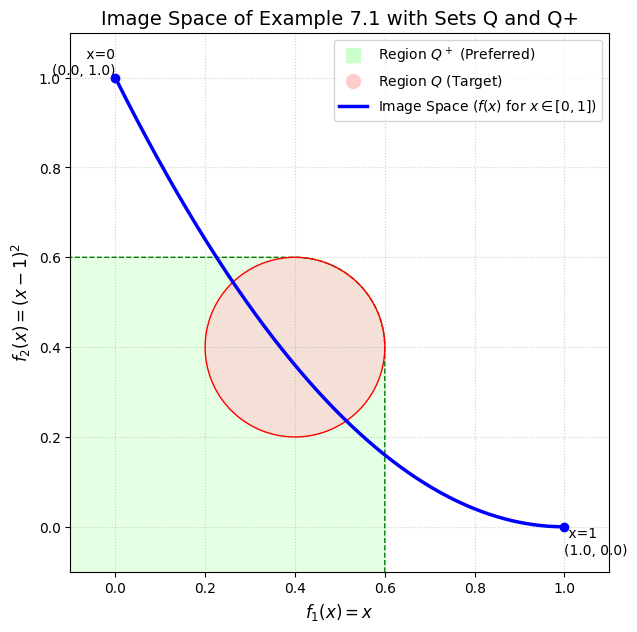

In [5]:
x_vals = np.linspace(0, 1, 500)
y1_vals = []
y2_vals = []

for x in x_vals:
    # f1, f2 nhận input là mảng/list (x[0])
    val = np.array([x]) 
    y1_vals.append(f1(val))
    y2_vals.append(f2(val))

y1_vals = np.array(y1_vals)
y2_vals = np.array(y2_vals)

# B. Tạo lưới điểm để vẽ vùng Q và Q_plus (Contour plot)
# Tạo lưới tọa độ y1, y2
grid_resolution = 400
y1_grid = np.linspace(-0.2, 1.2, grid_resolution)
y2_grid = np.linspace(-0.2, 1.2, grid_resolution)
Y1, Y2 = np.meshgrid(y1_grid, y2_grid)

# Tính giá trị q1 và q_plus trên lưới
Z_q1 = np.zeros_like(Y1)
Z_qplus = np.zeros_like(Y1)

for i in range(grid_resolution):
    for j in range(grid_resolution):
        pt = np.array([Y1[i, j], Y2[i, j]])
        Z_q1[i, j] = q1(pt)
        Z_qplus[i, j] = q_plus(pt)

# --- 3. VẼ ĐỒ THỊ ---
plt.figure(figsize=(7, 7))

# 1. Vẽ vùng Q_plus (Màu xanh lá nhạt)
# Vẽ contour tại mức 0 (ranh giới), và tô màu vùng >= 0
plt.contourf(Y1, Y2, Z_qplus, levels=[0, np.inf], colors=['#ccffcc'], alpha=0.5)
plt.contour(Y1, Y2, Z_qplus, levels=[0], colors='green', linestyles='--', linewidths=1)
# Hack label cho Q_plus bằng proxy artist (để hiện legend đẹp)
plt.plot([], [], color='#ccffcc', marker='s', markersize=10, linestyle='None', label='Region $Q^+$ (Preferred)')

# 2. Vẽ vùng Q (Hình tròn đỏ nhạt)
plt.contourf(Y1, Y2, Z_q1, levels=[0, np.inf], colors=['#ffcccc'], alpha=0.6)
plt.contour(Y1, Y2, Z_q1, levels=[0], colors='red', linewidths=1)
plt.plot([], [], color='#ffcccc', marker='o', markersize=10, linestyle='None', label='Region $Q$ (Target)')

# 3. Vẽ đường cong không gian ảnh (Image Space - Pareto Front candidates)
plt.plot(y1_vals, y2_vals, color='blue', linewidth=2.5, label='Image Space ($f(x)$ for $x \in [0,1]$)')

# Đánh dấu 2 điểm đầu mút
plt.scatter([y1_vals[0]], [y2_vals[0]], color='blue', zorder=5)
plt.text(y1_vals[0], y2_vals[0], f' x=0\n({y1_vals[0]:.1f}, {y2_vals[0]:.1f})', ha='right', va='bottom')

plt.scatter([y1_vals[-1]], [y2_vals[-1]], color='blue', zorder=5)
plt.text(y1_vals[-1], y2_vals[-1], f' x=1\n({y1_vals[-1]:.1f}, {y2_vals[-1]:.1f})', ha='left', va='top')

# --- 4. TRANG TRÍ ---
plt.title('Image Space of Example 7.1 with Sets Q and Q+', fontsize=14)
plt.xlabel('$f_1(x) = x$', fontsize=12)
plt.ylabel('$f_2(x) = (x-1)^2$', fontsize=12)

# Giới hạn trục để nhìn rõ
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

# Lưới và tỷ lệ 1:1 (Quan trọng để hình tròn không bị méo)
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')

plt.show()

In [6]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [7]:
x_init = np.array([-10.])

# Config

In [8]:
from ruamel.yaml import YAML
from ruamel.yaml.comments import CommentedSeq


def update_config(file_path, x_init_np):
    yaml = YAML()
    yaml.preserve_quotes = True
    yaml.indent(mapping=2, sequence=4, offset=2)

    with open(file_path, 'r', encoding='utf-8') as f_in:
        config = yaml.load(f_in)

    # Xử lý numpy array thành flow-style list cho đẹp
    val_list = x_init_np.tolist() if hasattr(x_init_np, 'tolist') else x_init_np
    flow_list = CommentedSeq(val_list)
    flow_list.fa.set_flow_style() 

    config['initialization']['x_init'] = flow_list
    
    # --- Cập nhật Phase 1 ---
    config['phase1']['gamma'] = 0.5
    config['phase1']['expo_gamma'] = 0.35 
    config['phase1']['max_iter'] = 500
    
    # --- Cập nhật Phase 2 (Algorithm 1-A Parameters) ---
    config['phase2']['mu'] = 0.0001
    config['phase2']['init_params'] = 1.0
    config['phase2']['max_iter'] = 2000
    
    # Các tham số số mũ hội tụ 
    config['phase2']['expo_lambda'] = 0.55    # Giảm: Bước nhảy (Điều kiện: 0.5 < l <= 1)
    config['phase2']['expo_alpha'] = 0.45     # Giảm: Trọng số mục tiêu (Điều kiện: l + a <= 1 => a < 0.5)

    
    # [MỚI] Thêm expo_beta và expo_gamma
    config['phase2']['expo_beta'] = 0.4      # Tăng: Phạt tập C (b_C < 0)
    config['phase2']['expo_gamma'] = 0.5    # Tăng: Phạt tập Q+ (b_Q < 0)

    # Ghi lại vào file
    with open(file_path, 'w', encoding='utf-8') as f_out:
        yaml.dump(config, f_out)
    
    print(f"✅ Đã cập nhật xong file: {file_path}")

config_file = 'config.yaml'
update_config(config_file, x_init)
print("\n" + "="*30)
print("NỘI DUNG FILE CONFIG SAU KHI SỬA:")
print("="*30)
with open(config_file, 'r', encoding='utf-8') as f_in:
    print(f_in.read())

✅ Đã cập nhật xong file: config.yaml

NỘI DUNG FILE CONFIG SAU KHI SỬA:
data:
  test_ray:
    -   - 1.0
        - 0.0
    -   - 0.9965844930066698
        - 0.08257934547233232
    -   - 0.9863613034027223
        - 0.1645945902807339
    -   - 0.9694002659393304
        - 0.24548548714079912
    -   - 0.9458172417006346
        - 0.32469946920468346
    -   - 0.9157733266550574
        - 0.4016954246529694
    -   - 0.8794737512064891
        - 0.4759473930370735
    -   - 0.8371664782625285
        - 0.5469481581224268
    -   - 0.7891405093963936
        - 0.6142127126896678
    -   - 0.7357239106731316
        - 0.677281571625741
    -   - 0.6772815716257411
        - 0.7357239106731316
    -   - 0.6142127126896678
        - 0.7891405093963936
    -   - 0.5469481581224269
        - 0.8371664782625285
    -   - 0.4759473930370736
        - 0.8794737512064891
    -   - 0.40169542465296953
        - 0.9157733266550574
    -   - 0.32469946920468357
        - 0.9458172417006346
    -   

## Cloud

In [9]:
pf_cloud, pf_targets = generate_pareto_grid(
    f_func=f, 
    c_funcs=[c1, c2], 
    q_plus_func=q_plus, 
    resolution=500
)

--- Đang quét lưới 500x500 điểm ---
-> Tìm thấy 250000 điểm thỏa mãn miền C.
-> Lọc còn 93500 điểm thỏa mãn Q+ (Cloud).
-> Kết quả: 187 điểm Pareto.


In [11]:
# np.save(f"test/{case}/pf_true.npy", results["pareto_f"])
# np.save(f"test/{case}/target_space.npy", pf_cloud)

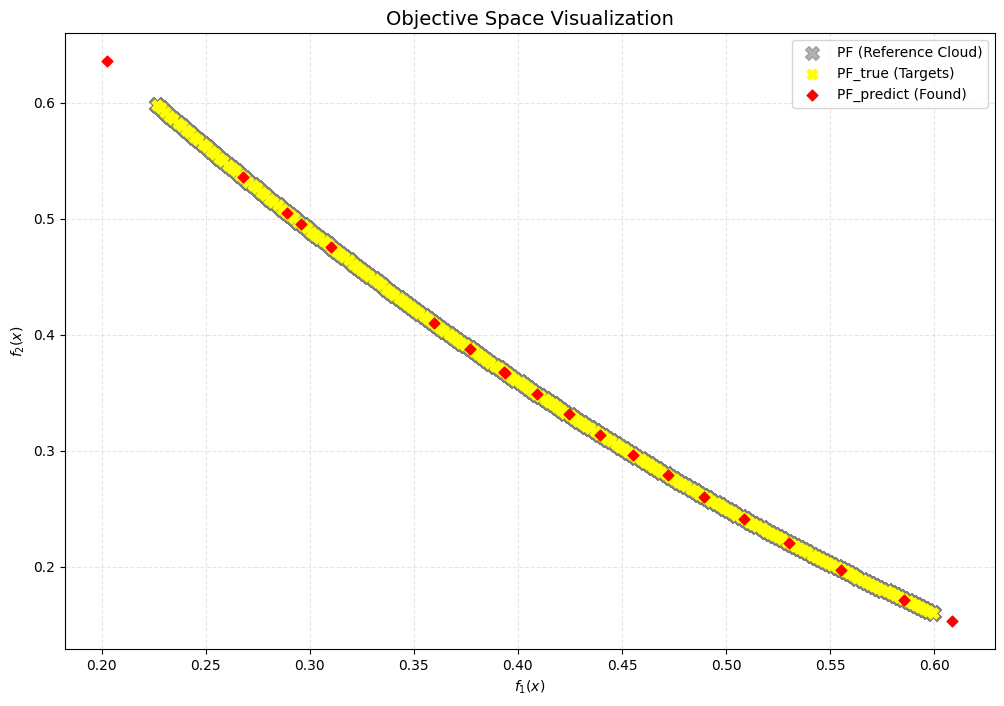

In [12]:
visualize_pareto_front(
    pf_pred=results["pareto_f"], 
    pf_cloud=pf_cloud,   
    pf_targets=pf_targets,
    title="Objective Space Visualization",
    figsize=(12, 8)
)

# Dynamic

In [25]:
from main_dynamic import run_experiment as run_experiment_dynamic

In [26]:
results_dynamic = run_experiment_dynamic(prob)

=== BẮT ĐẦU PHASE 1: TÌM ĐIỂM KHẢ THI ===
Khởi tạo: x0: [-10.]
Chiếu lên C được: x: [0.]


  0%|          | 1/500 [00:00<00:02, 168.07it/s]


Hội tụ tại vòng lặp 1
+---+-------+---------+----------+------------+----------+----------+
| k | x_new | gamma_k | y        | z_proj     |   e_x    |   e_f    |
+---+-------+---------+----------+------------+----------+----------+
| 0 | [0.]  | 0.5000  | [0., 1.] | [0. , 0.6] | 0.399999 | 0.400000 |
+---+-------+---------+----------+------------+----------+----------+
-> Điểm khả thi (Feasible Point): [0.4]

=== TÌM GIỚI HẠN PARETO: OPTIM 1 OBJ CỦA F ===


-> Cực tiểu chiều 0: 0.2240630972098213
-> Cực tiểu chiều 1: 0.14144484809271618
-> Điểm lý tưởng z*: [0.2241 0.1414]

=== BẮT ĐẦU PHASE 2: SCALARIZATION (MULTI-RAY) - ALGORITHM 1-A ===
Running Ray 1/20: [1. 0.]
Params: alpha=k^-0.45, lambda=k^-0.55, beta=k^0.4, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.014893
Running Ray 2/20: [0.9966 0.0826]
Params: alpha=k^-0.45, lambda=k^-0.55, beta=k^0.4, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Running Ray 3/20: [0.9864 0.1646]
Params: alpha=k^-0.45, lambda=k^-0.55, beta=k^0.4, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Running Ray 4/20: [0.9694 0.2455]
Params: alpha=k^-0.45, lambda=k^-0.55, beta=k^0.4, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Running Ray 5/20: [0.9458 0.3247]
Params: alpha=k^-0.45, lambda=k^-0.55, beta=k^0.4, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Running Ray 6/20: [0.9158 0.4017]
Params: alpha

# Optim HV

In [17]:
from functions_hv_python3 import HyperVolume

def calculate_hv_score(pareto_f, prob, ref_point):
    """Tính Hypervolume, loại bỏ điểm vi phạm ràng buộc Q+"""
    valid_points = []
    tol = 1e-3
    for point in pareto_f:
        # Kiểm tra feasibility với Q+
        point_proj = prob.proj_Qplus(point)
        dist_Q = np.linalg.norm(point - point_proj)
        
        # Kiểm tra nằm trong vùng Reference
        is_dominated_by_ref = np.all(point < ref_point)
        
        if dist_Q < tol and is_dominated_by_ref:
            valid_points.append(point.tolist())
            
    if len(valid_points) < 2: return 0.0
    
    hv = HyperVolume(ref_point)
    return hv.compute(valid_points)

In [43]:
def generate_valid_params():
    """
    Sinh các tổ hợp tham số thỏa mãn điều kiện lý thuyết hội tụ:
    1. 0.5 < expo_lambda <= 1
    2. expo_alpha > 0
    3. expo_lambda + expo_alpha <= 1 (Để đảm bảo tổng hệ số tiến về 0 đúng tốc độ) - Tuỳ chọn chặt
       Hoặc điều kiện lỏng hơn: 0 < expo_beta, expo_gamma < expo_lambda
    """
    
    # Không gian tìm kiếm thô
    grid = {
        'expo_lambda': [0.6, 0.75, 0.8],
        'expo_alpha':  [0.1, 0.3, 0.4], 
        'expo_beta':   [0.3, 0.5],
        'expo_gamma':  [0.3, 0.5],
        'init_params': [1.0, 2.0]
    }
    
    keys, values = zip(*grid.items())
    raw_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    valid_combinations = []
    for p in raw_combinations:
        # --- KIỂM TRA ĐIỀU KIỆN ---
        cond1 = 0.5 < p['expo_lambda'] <= 1.0
        cond2 = p['expo_lambda'] + p['expo_alpha'] <= 1
        cond3 = p['expo_beta'] < p['expo_lambda']
        cond4 = p['expo_gamma'] < p['expo_lambda']
        
        if cond1 and cond2 and cond3:
            valid_combinations.append(p)
            
    return valid_combinations

In [44]:
base_cfg = load_config()
base_cfg['phase2']['max_iter'] = 1000 
base_cfg['phase2']['mu'] = 0.0001

# 1. Chạy Phase 1 (Tìm điểm khả thi ban đầu)
print("-> Đang tìm điểm Feasible (Phase 1)...")
x_feasible, _, _, _ = solve_CQ_feasible(
    prob.objective_func, prob.jacobian, prob.proj_C, prob.proj_Qplus,
    base_cfg['initialization']['x_init'],
    gamma=base_cfg['phase1']['gamma'] , max_iter=base_cfg['phase1']['max_iter']
)

print("-> Đang tìm các điểm cực trị để xác định Z* và Ref Point...")
z_vals = []
nadir_vals = []

for dim in range(2):
    # Tìm MIN
    x_min, _ = optim_Universal(prob, x_feasible, target_dim=dim, mode="min", max_iter=500, mu=0.001)
    val_min = prob.objective_func(x_min)[dim]
    z_vals.append(val_min)
    
    # Tìm MAX 
    x_max, _ = optim_Universal(prob, x_feasible, target_dim=dim, mode="max", max_iter=500, mu=0.001)
    val_max = prob.objective_func(x_max)[dim]
    nadir_vals.append(val_max)
    print(f"   Dim {dim}: Min={val_min:.4f}, Max={val_max:.4f}")
z_star = np.array(z_vals) - 0.05
ref_point = np.array(nadir_vals) + np.abs(np.array(nadir_vals)) * 0.1 + 0.5 
print(f"-> Z* (Ideal): {z_star}")
print(f"-> Ref Point (HV): {ref_point}")

-> Đang tìm điểm Feasible (Phase 1)...
Khởi tạo: x0: [-10.]
Chiếu lên C được: x: [0.]


  0%|          | 1/500 [00:00<00:04, 113.36it/s]


Hội tụ tại vòng lặp 1
+---+-------+---------+----------+------------+----------+----------+
| k | x_new | gamma_k | y        | z_proj     |   e_x    |   e_f    |
+---+-------+---------+----------+------------+----------+----------+
| 0 | [0.]  | 0.5000  | [0., 1.] | [0. , 0.6] | 0.400000 | 0.400000 |
+---+-------+---------+----------+------------+----------+----------+
-> Đang tìm các điểm cực trị để xác định Z* và Ref Point...


   Dim 0: Min=0.1501, Max=0.8195
   Dim 1: Min=0.0795, Max=0.8105
-> Z* (Ideal): [0.1001 0.0295]
-> Ref Point (HV): [1.4015 1.3915]


In [45]:
# ==============================================================================
# 3. GRID SEARCH (PHASE 2 - ALGORITHM 1-A)
# ==============================================================================
# Lấy tập params hợp lệ
param_combinations = generate_valid_params()
print(f"\n=== BẮT ĐẦU GRID SEARCH TRÊN {len(param_combinations)} CẤU HÌNH HỢP LỆ ===")

# Dùng tập rays thưa để test nhanh (Ví dụ 10 tia)
test_rays_subset = base_cfg['data']['test_ray']

results_log = []
best_hv = -1.0
best_params = None

for idx, params in enumerate(param_combinations):
    # In tiến độ gọn
    if idx % 5 == 0: print(f"Processing {idx}/{len(param_combinations)}...")
        
    pareto_f_temp = []
    
    # Chạy Alg 1-A với cấu hình hiện tại
    for r in test_rays_subset:
        x_final, _ = optim_Scalarization(
            prob=prob,
            x_feasible=x_feasible,  
            r=r, 
            z_star=z_star,
            # Các tham số tĩnh
            max_iter=base_cfg['phase2']['max_iter'],
            mu=base_cfg['phase2']['mu'],
            verbose=False,
            # --- CÁC THAM SỐ ĐANG TỐI ƯU ---
            init_params=params['init_params'],
            expo_alpha=params['expo_alpha'],
            expo_lambda=params['expo_lambda'],
            expo_beta=params['expo_beta'],
            expo_gamma=params['expo_gamma'],
        )
        pareto_f_temp.append(prob.objective_func(x_final))
    
    # Tính HV
    hv_score = calculate_hv_score(np.array(pareto_f_temp), prob, ref_point)
    
    # Lưu log
    log_entry = params.copy()
    log_entry['HV'] = hv_score
    results_log.append(log_entry)
    
    # Cập nhật Best
    if hv_score > best_hv:
        best_hv = hv_score
        best_params = params
        print(f"   [New Best] Config {idx}: HV = {best_hv:.6f}")


=== BẮT ĐẦU GRID SEARCH TRÊN 40 CẤU HÌNH HỢP LỆ ===
Processing 0/40...
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.034392
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.031184
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.012483
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.003221
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.000112
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q:

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.006478
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.012733
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.012375
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000638
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.045510
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q:

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q:

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000002, Gap Q: 0.018176
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.031182
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.021581
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.027256
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.3, lambda=k^-0.6, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q:

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q:

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.019568
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.007758
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000007
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.007363
   [New Best] Config 20: HV = 1.363144
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.012481
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach 

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.028586
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.003728
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.019208
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.019655
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.027371
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.016553
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000027
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.75, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000

-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.007704
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.3, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q:

-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.049217
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.049854
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000001, Gap Q: 0.014667
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.014847
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.014736
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.1, lambda=k^-0.8, beta=k^0.5, gamma=k^0.5
-> Reach max_iter. Final Gap C: 0.000000, Gap Q:

In [47]:
best_params

{'expo_lambda': 0.6,
 'expo_alpha': 0.4,
 'expo_beta': 0.5,
 'expo_gamma': 0.3,
 'init_params': 1.0}

In [66]:
pareto_f_temp = []
for r in test_rays_subset:
        x_final, _ = optim_Scalarization(
            prob=prob,
            x_feasible=x_feasible,  
            r=r, 
            z_star=z_star,
            # Các tham số tĩnh
            max_iter=base_cfg['phase2']['max_iter'],
            mu=base_cfg['phase2']['mu'],
            verbose=False,
            # --- CÁC THAM SỐ ĐANG TỐI ƯU ---
            init_params=1.0,
            expo_alpha=0.4,
            expo_lambda=0.6,
            expo_beta=0.5,
            expo_gamma=0.3,
        )
        pareto_f_temp.append(prob.objective_func(x_final))
    
    # Tính HV
hv_score = calculate_hv_score(np.array(pareto_f_temp), prob, ref_point)
hv_score

Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.002353
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.020930
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.003219
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5, gamma=k^0.3
-> Reach max_iter. Final Gap C: 0.000000, Gap Q: 0.000000
Params: alpha=k^-0.4, lambda=k^-0.6, beta=k^0.5,

np.float64(1.361424329638196)

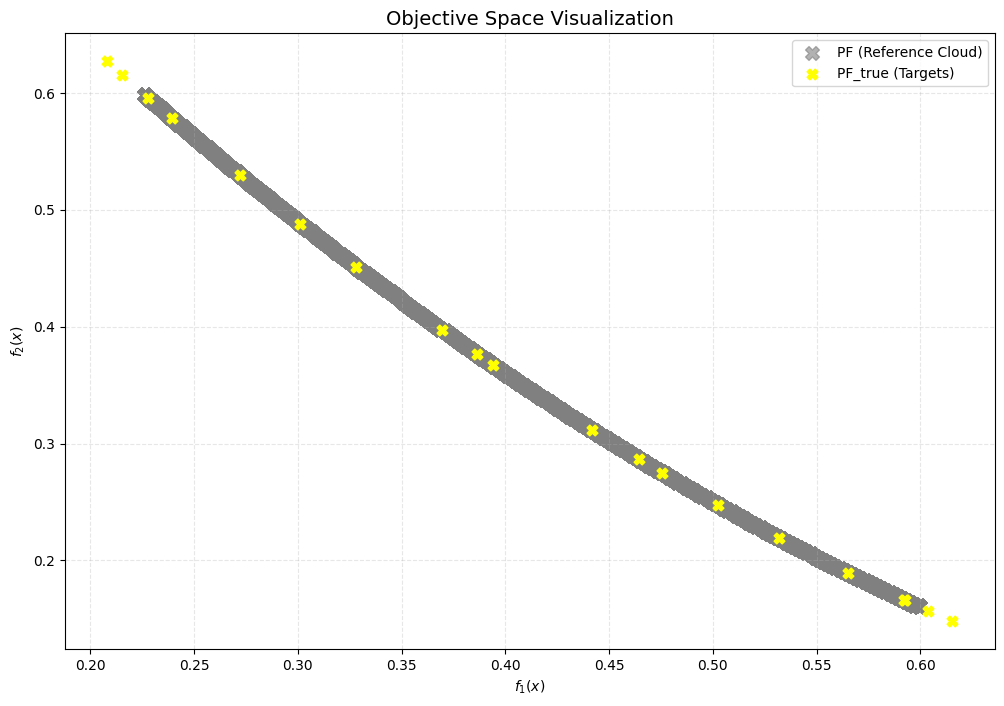

In [67]:
visualize_pareto_front(
    pf_targets=np.array(pareto_f_temp), 
    pf_cloud=pf_cloud,   
#     pf_targets=results["pareto_f"],
    title="Objective Space Visualization",
    figsize=(12, 8)
)

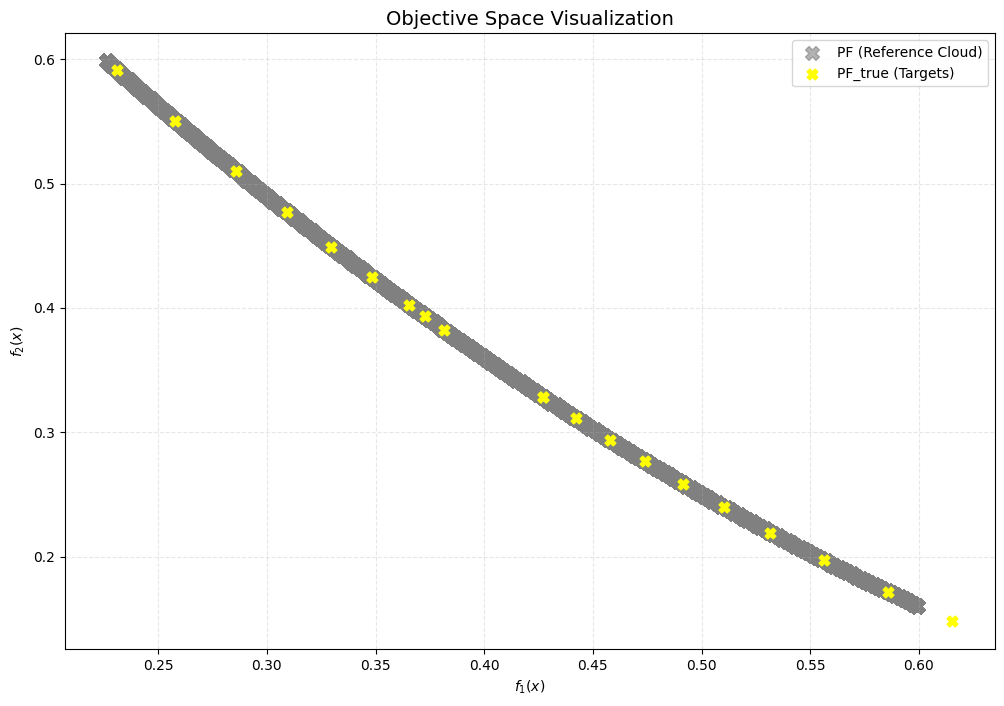

In [30]:
visualize_pareto_front(
    pf_targets=results_dynamic["pareto_f"], 
    pf_cloud=pf_cloud,   
#     pf_targets=results["pareto_f"],
    title="Objective Space Visualization",
    figsize=(12, 8)
)

In [16]:
# np.save(f"test/{case}/pf_dynamic_true.npy", results_dynamic["pareto_f"])